## MT3DMS Supplemental Guide Problem 6.3.1

This example is for zero-order production in a uniform flow field.
It is based on example problem 6.3.1 described in Zheng 2010. The
problem consists of a one-dimensional model grid with inflow into
the first cell and outflow through the last cell. This example is
simulated with a GWT model in, which receives flow information from
a GWF model. Results from the GWT model are compared with the results
from a MT3DMS simulation that uses flows from a MODFLOW-2005 simulation.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
example_name = "ex-gwt-mt3dsupp631"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 2  # Number of periods
nlay = 1  # Number of layers
nrow = 1  # Number of rows
ncol = 101  # Number of columns
delr = 0.16  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 1.0  # Top of the model ($m$)
botm = 0  # Layer bottom elevation ($m$)
specific_discharge = 0.1  # Specific discharge ($md^{-1}$)
longitudinal_dispersivity = 1.0  # Longitudinal dispersivity ($m$)
porosity = 0.37  # Porosity of mobile domain (unitless)
zero_order_decay = -2.0e-3  # Zero-order production rate ($mg/L d^{-1}$)
source_duration = 160.0  # Source duration ($d$)
total_time = 840.0  # Simulation time ($t$)
obs_xloc = 8.0  # Observation x location ($m$)

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_mf6gwf(sim_folder):
    print(f"Building mf6gwf model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwf")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_ds = (
        (source_duration, 1, 1.0),
        (total_time - source_duration, 1, 1.0),
    )
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=0,
        k=1.0,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=1.0)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, ncol - 1), 1.0]])
    wel_spd = {
        0: [[(0, 0, 0), specific_discharge * delc * top, 1.0]],
        1: [[(0, 0, 0), specific_discharge * delc * top, 0.0]],
    }
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=wel_spd,
        pname="WEL-1",
        auxiliary=["CONCENTRATION"],
    )
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    return sim


def build_mf6gwt(sim_folder):
    print(f"Building mf6gwt model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwt")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    pertim1 = source_duration
    pertim2 = total_time - source_duration
    tdis_ds = ((pertim1, 16, 1.0), (pertim2, 84, 1.0))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim, linear_acceleration="bicgstab")
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwtic(gwt, strt=0)
    flopy.mf6.ModflowGwtmst(
        gwt, zero_order_decay=True, porosity=porosity, decay=zero_order_decay
    )
    flopy.mf6.ModflowGwtadv(gwt)
    flopy.mf6.ModflowGwtdsp(
        gwt,
        xt3d_off=True,
        alh=longitudinal_dispersivity,
        ath1=longitudinal_dispersivity,
    )
    pd = [
        ("GWFHEAD", "../mf6gwf/flow.hds", None),
        ("GWFBUDGET", "../mf6gwf/flow.bud", None),
    ]
    flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)
    sourcerecarray = [["WEL-1", "AUX", "CONCENTRATION"]]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    obsj = int(obs_xloc / delr) + 1
    obs_data = {
        f"{name}.obs.csv": [
            ("myobs", "CONCENTRATION", (0, 0, obsj)),
        ],
    }
    obs_package = flopy.mf6.ModflowUtlobs(
        gwt, digits=10, print_input=True, continuous=obs_data
    )
    return sim


def build_mf2005(sim_folder):
    print(f"Building mf2005 model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder, "mf2005")
    mf = flopy.modflow.Modflow(modelname=name, model_ws=sim_ws, exe_name="mf2005")
    pertim1 = source_duration
    pertim2 = total_time - source_duration
    perlen = [pertim1, pertim2]
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        nper=nper,
        perlen=perlen,
    )
    bas = flopy.modflow.ModflowBas(mf)
    lpf = flopy.modflow.ModflowLpf(mf)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    chd = flopy.modflow.ModflowChd(mf, stress_period_data=[[0, 0, ncol - 1, 1.0, 1.0]])
    wel_spd = {
        0: [[0, 0, 0, specific_discharge * delc * top]],
        1: [[0, 0, 0, specific_discharge * delc * top]],
    }
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)
    return mf


def build_mt3dms(sim_folder, modflowmodel):
    print(f"Building mt3dms model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(workspace, sim_folder, "mt3d")
    mt = flopy.mt3d.Mt3dms(
        modelname=name,
        model_ws=sim_ws,
        exe_name="mt3dms",
        modflowmodel=modflowmodel,
        ftlfilename="../mf2005/mt3d_link.ftl",
    )
    dt0 = 10.0
    obsj = int(obs_xloc / delr) + 1
    btn = flopy.mt3d.Mt3dBtn(
        mt, laycon=0, prsity=porosity, obs=[(0, 0, obsj)], dt0=dt0, ifmtcn=1
    )
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=0)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=longitudinal_dispersivity)
    rc1 = zero_order_decay
    ireact = 100  # zero order decay
    rct = flopy.mt3d.Mt3dRct(mt, igetsc=0, ireact=ireact, rc1=rc1)
    ssm_spd = {0: [0, 0, 0, 1.0, 2], 1: [0, 0, 0, 0.0, 2]}
    ssm = flopy.mt3d.Mt3dSsm(mt, mxss=3, stress_period_data=ssm_spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    return mt


def build_models(sim_name):
    sim_mf6gwf = build_mf6gwf(sim_name)
    sim_mf6gwt = build_mf6gwt(sim_name)
    sim_mf2005 = build_mf2005(sim_name)
    sim_mt3dms = build_mt3dms(sim_name, sim_mf2005)
    return sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms


def write_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    sim_mf6gwf.write_simulation(silent=silent)
    sim_mf6gwt.write_simulation(silent=silent)
    sim_mf2005.write_input()
    sim_mt3dms.write_input()


@timed
def run_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    success, buff = sim_mf6gwf.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = sim_mf6gwt.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = sim_mf2005.run_model(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = sim_mt3dms.run_model(
        silent=silent, normal_msg="Program completed", report=True
    )
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (5, 3)


def plot_results(sims, idx):
    _, sim_mf6gwt, _, sim_mt3dms = sims
    with styles.USGSPlot():
        mf6gwt_ra = sim_mf6gwt.get_model("trans").obs.output.obs().data
        fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        axs.plot(
            mf6gwt_ra["totim"],
            mf6gwt_ra["MYOBS"],
            marker="o",
            ls="none",
            mec="blue",
            mfc="none",
            markersize="4",
            label="MODFLOW 6 GWT",
        )

        sim_ws = sim_mt3dms.model_ws
        fname = os.path.join(sim_ws, "MT3D001.OBS")
        mt3dms_ra = sim_mt3dms.load_obs(fname)
        colname = mt3dms_ra.dtype.names[2]
        axs.plot(
            mt3dms_ra["time"],
            mt3dms_ra[colname],
            linestyle="-",
            color="k",
            label="MT3DMS",
        )
        axs.set_xlabel("Time (days)")
        axs.set_ylabel("Normalized Concentration (unitless)")
        axs.legend()

        if plot_show:
            plt.show()
        if plot_save:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}.png"
            fpth = figs_path / fname
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

Building mf6gwf model...ex-gwt-mt3dsupp631
Building mf6gwt model...ex-gwt-mt3dsupp631
Building mf2005 model...ex-gwt-mt3dsupp631
Building mt3dms model...ex-gwt-mt3dsupp631


run_models took 104.82 ms


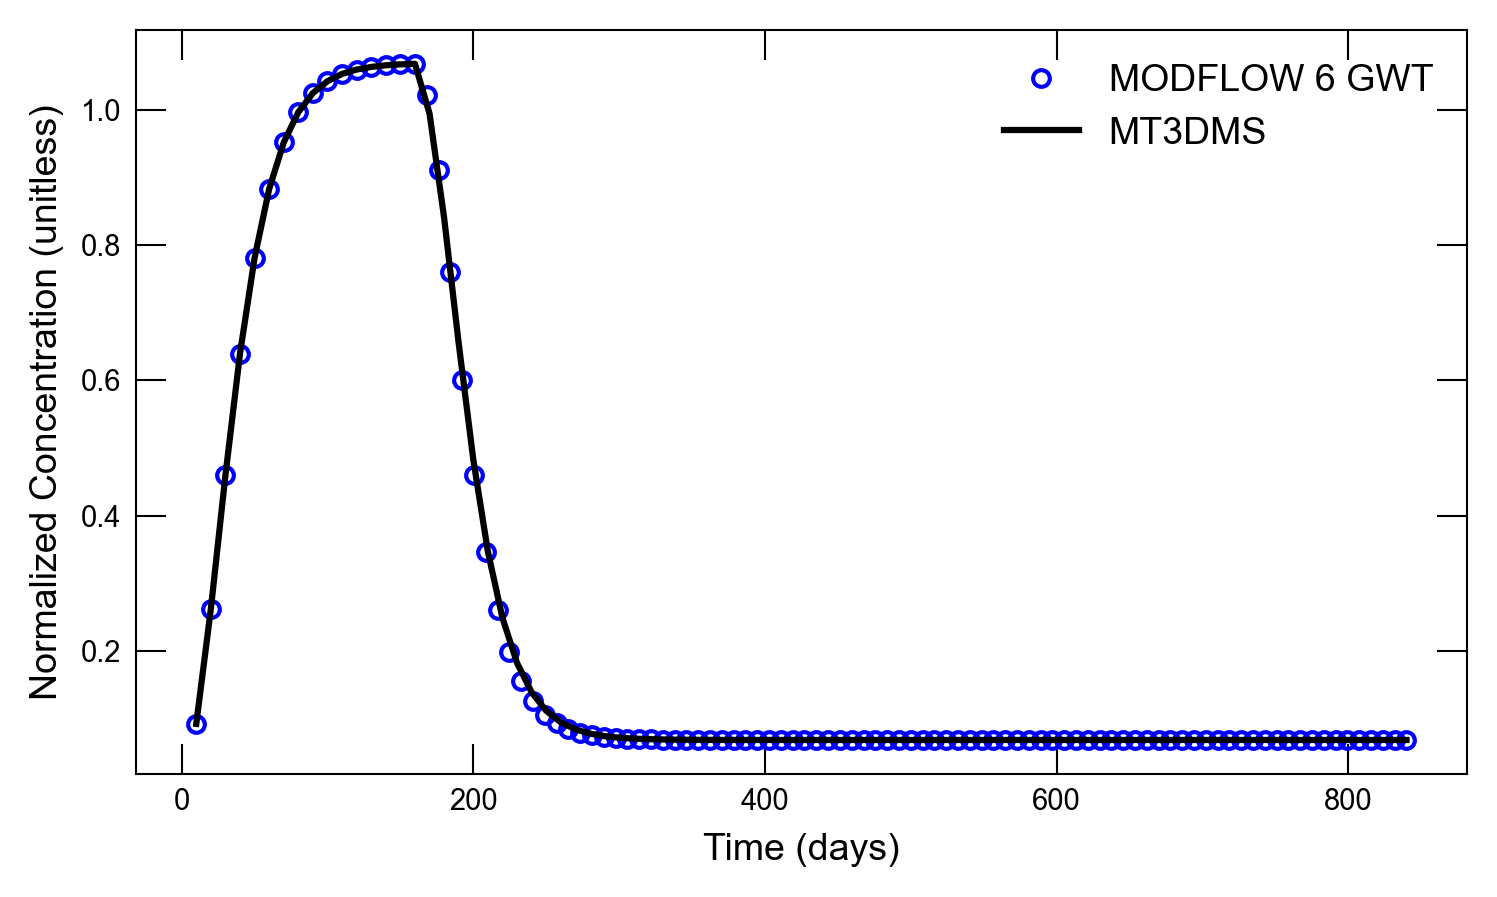

In [5]:
def scenario(idx, silent=True):
    sim = build_models(example_name)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, idx)


scenario(0)